# Homework 6: Optimization, Modeling, and Prediction

Name: Jordan Pinkava
    
Course: BMGT404
    
Section: 0201
    
Date: 05/09/2024

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from scipy.optimize import linprog
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Part 1: Optimization

Our non-profit, TerpBakes, is excited to sell our new terrapin-shaped peanut butter cookies at UMD. We got a donation of 10,000 cups of peanut butter and 4,000 cups of maple syrup, which are the two ingredients needed for these special cookies. We will sell two varieties, regular and low-sugar. The low-sugar cookies will require a different amount of ingredients as compared to the regular cookies. 

We will get a $2.14 profit for our regular cookies, and for our low-sugar options we will yield a 4.04 profit. 

One regular cookie will require .5 cups of peanut butter and 1.25 cups of maple syrup. A low-sugar cookie will require 1.05 cups of peanut butter and .125 cups of maple syrup. 

Through the sales of these cookies, 100% of proceeds will be donated to students who are struggling. TerpBakes wants to maximize the amount of profit so that we can donate as much funds as possible to these students in need. 

In [2]:
#1 defining some variables to avoid magic numbers in our code

#donations
pb_donor = 10000
syrup_donor = 4000
#profit
regular_cookie_cost = 2.14
lowsugar_cookie_cost = 4.04
#ingredients
regular_cookie_pb = 0.5
regular_cookie_sy = 1.25
lowsugar_cookie_pb = 1.05
lowsugar_cookie_sy = 0.125

In [3]:
coefs = [-(regular_cookie_cost), -(lowsugar_cookie_cost)]

inequality_constraint_matrix = [[regular_cookie_pb, lowsugar_cookie_pb], [regular_cookie_sy, lowsugar_cookie_sy]]
inequality_constraint_vector = [pb_donor, syrup_donor] 

result = linprog(coefs, inequality_constraint_matrix, inequality_constraint_vector)
result

           con: array([], dtype=float64)
 crossover_nit: 0
         eqlin:  marginals: array([], dtype=float64)
  residual: array([], dtype=float64)
           fun: -38986.4
       ineqlin:  marginals: array([-3.826 , -0.1816])
  residual: array([0., 0.])
         lower:  marginals: array([0., 0.])
  residual: array([2360., 8400.])
       message: 'Optimization terminated successfully. (HiGHS Status 7: Optimal)'
           nit: 2
         slack: array([0., 0.])
        status: 0
       success: True
         upper:  marginals: array([0., 0.])
  residual: array([inf, inf])
             x: array([2360., 8400.])

### Objective function: 
We negate this because we are performing a maximization problem. 

-2.14x -4.04y

### Decision Variable: 
We have 2 x and 2 y variables, one for each cookies needed ingredient amounts. 

x1, x2, y1, y2

### Constraints: 
We need to have the coefficient amount of ingredients in each cookie, and we are limited to the amount on the right hand side of our constraint equations. 

Peanut Butter Constraint: .5x + 1.05y >= 10,000

Syrup Constraint: 1.25x + .125y >= 4,000

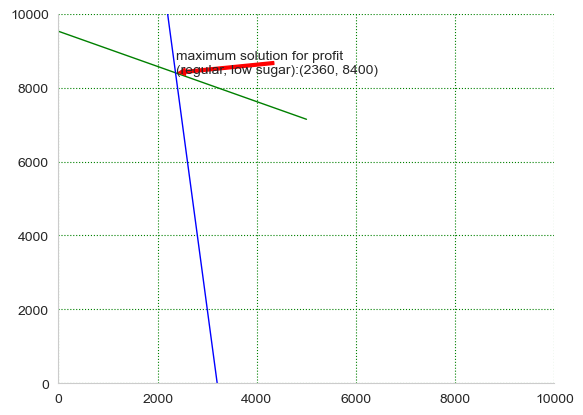

In [29]:
fig, ax = plt.subplots()
plt.axis([0., 10000., 0., 10000.])
ax.grid(True, which='both', color='g', linestyle=':')
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

x_vals = np.linspace(0,5000, 100)
y1 = (10000 - .5 * x_vals) /1.05  
y2 = (4000-1.25*x_vals)/.125 

plt.plot(x_vals, y1, '-g', linewidth=1)
plt.plot(x_vals, y2, '-b', linewidth=1)

plt.annotate(f'maximum solution for profit \n(regular, low sugar):({result.x[0]:.0f}, {result.x[1]:.0f})',
    xy=(result.x[0], result.x[1]),
    xytext=(result.x[0], result.x[1] + 0.05),
    arrowprops={"arrowstyle":"simple", "color":'r'})
plt.show()

Based on the findings above, we now know that we need to make 2360 regular cookies and 8400 low sugar cookies to achieve the maximum profit desired, which is $38,986.4. This means that we will be able to donate nearly 40k to the students in need, which is great for TerpsBake and for the UMD campus community.

# Part 2: Modeling and Prediction

I am an analyst at HireTheTerps and I want to predict how much the company will need to budget for some of our future hires. I will parse through a salary database to see how the years of experience impacts the salary of the employee. 

First, I will connect the database so I can easily perform my analysis on the salary data. I want to make sure that all of my variables are numeric before training them and that I properly format my dataframe.

In [5]:
#3 
#connect and load in the data
connection = sqlite3.connect('HW6-salary.db')
salary = pd.read_sql('SELECT * FROM salary', connection, index_col = ["id"])
#make sure all data is numeric
salary = salary.astype(float)
#view the salaries we have in the database already
salary["salary"].values

array([ 39343.,  46205.,  37731.,  43525.,  39891.,  56642.,  60150.,
        54445.,  64445.,  57189.,  63218.,  55794.,  56957.,  57081.,
        61111.,  67938.,  66029.,  83088.,  81363.,  93940.,  91738.,
        98273., 101302., 113812., 109431., 105582., 116969., 112635.,
       122391., 121872.])

In [6]:
#view the database we desire to work with
salary.head(10)

,years_experience,salary
id,,
1,1.1,39343.0
2,1.3,46205.0
3,1.5,37731.0
4,2.0,43525.0
5,2.2,39891.0
6,2.9,56642.0
7,3.0,60150.0
8,3.2,54445.0
9,3.2,64445.0


The next step is training our model. Before training, we need to split the data to a near 75/25 split, then we can fit it upsing out LinearRegression function. This will help use make sure we are training our model correctly and effectively before testing our model and using it for prediction later.

In [9]:
#4 
#randomly splitting our data for what will be trained and tested
X_train, X_test, y_train, y_test = train_test_split(salary['years_experience'].values.reshape(-1, 1),
    salary['salary'].values, random_state=11)

In [10]:
# making sure we achieve close to a 75/25 split, which is an optimal split for our data
print(X_train.size, 'items --', X_train.size/(X_train.size + X_test.size) * 100)
print(X_test.size, 'items --', X_test.size/(X_train.size + X_test.size) * 100)

22 items -- 73.33333333333333
8 items -- 26.666666666666668


In [11]:
#fit our model for training
linear_regression = LinearRegression()
linear_regression.fit(X=X_train, y=y_train)

LinearRegression()

Below, we can visualize what our data looks like and what our model sees so far. This shows the model we created through the previous steps. Through this, we can see that there is a positive linear relationship between years of experience and salary. Thus, when the years of experience increase, so will the salary of the employee. 

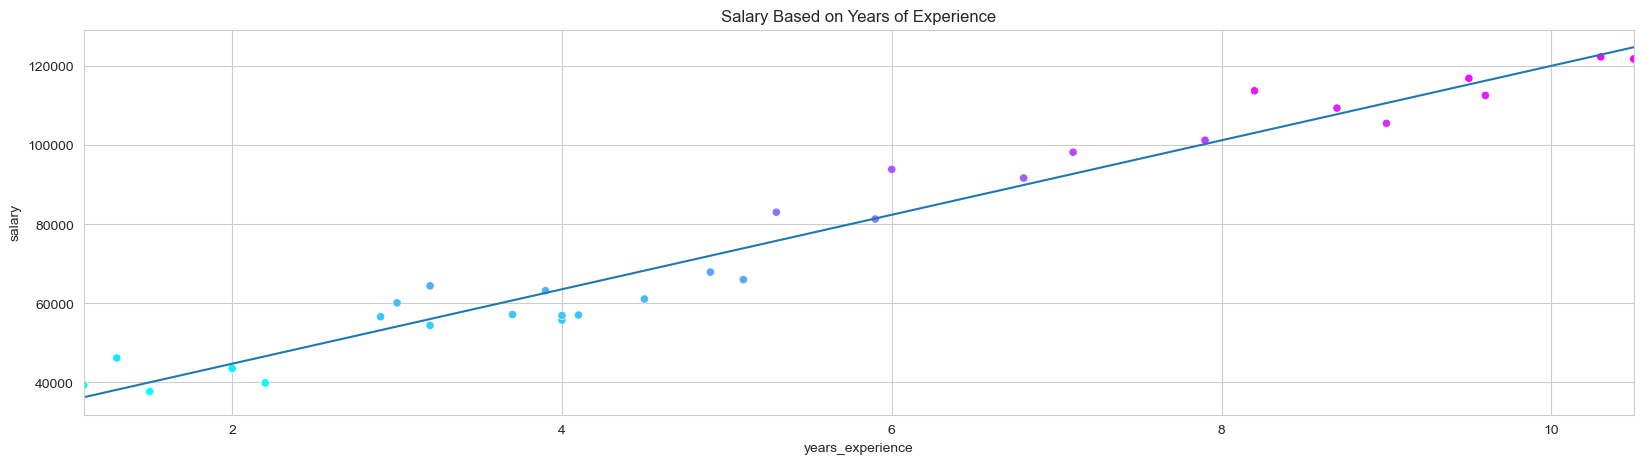

In [42]:
sns.set_style('whitegrid')
fig, axes = plt.subplots()
fig.set_size_inches(20, 5)
axes = sns.scatterplot(data = salary, x='years_experience', y='salary', hue = "salary", palette = "cool", legend = False)
axes.set_xlim(salary['years_experience'].min(), salary['years_experience'].max())
axes.set_title('Salary Based on Years of Experience');

x = np.linspace(salary['years_experience'].min(), salary['years_experience'].max(), 100)
y = linear_regression.predict(x.reshape(-1, 1))
plt.plot(x, y);

Now that we have created and trained our model, we are ready to give the model a test! We will test the model and access for accuracy by looking at statistical methods that explain the accuracy of our model. 

In [13]:
#6 create a prediction/test
expected = y_test
predicted = linear_regression.predict(X_test)

#show two predictions vs expected values
for p, e in zip(predicted[::5], expected[::5]):  
    print('Predicted: %.2f, Expected: %.2f' % (p, e))

Predicted: 72074.29, Expected: 67938.00
Predicted: 63594.76, Expected: 55794.00


Now that we have seen some predictions versus our expected values, we can see whether or not our model is actually accurate. Below, I calculated the R-squared, which will tell us how well our model can make predictions. 

In [16]:
r2 = metrics.r2_score(expected, predicted)
print(f"The R-Squared of our model is {r2:.2f}.")

The R-Squared of our model is 0.93.


Given the R-Squared value above, it appears that our model is 93.4% accurate in making predictions and therefore is a strong model to use for further analysis!

HireTheTerps wants to hire seven people of the following experience levels: 12, 15, 17, 18, 21, 23, 26. Below, we can use our model to predict the salaries of these employees. This is useful in letting us know the type of budget we need for our future employees salaries. 

In [20]:
#7
#create a list of years of experience
years = [12, 15, 17, 18, 21, 23, 26]

#create a loop to calculate the salary based on years of experience
for year in years:
    prediction = linear_regression.coef_ * year + linear_regression.intercept_
    print(f"The salary prediction for {year} years of experience is {prediction}")

The salary prediction for 12 years of experience is [138968.32008848]
The salary prediction for 15 years of experience is [167233.40500333]
The salary prediction for 17 years of experience is [186076.79494655]
The salary prediction for 18 years of experience is [195498.48991817]
The salary prediction for 21 years of experience is [223763.57483301]
The salary prediction for 23 years of experience is [242606.96477624]
The salary prediction for 26 years of experience is [270872.04969109]


Finally, we want to vizualize our predictions given the model we have created and the predictions it has. Below, we use seaborn to help us see expected salaries based on experience levels. 

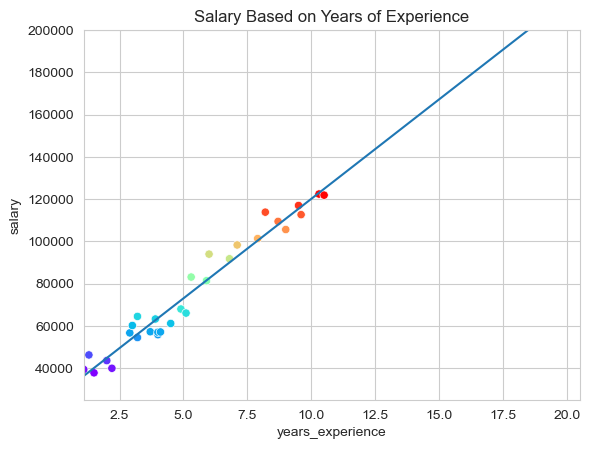

In [45]:
#8 
axes = sns.scatterplot(data=salary, x='years_experience', y='salary', hue="salary", palette='rainbow', legend=False)  
axes.set_ylim(25000, 200000)   
axes.set_xlim(min(salary['years_experience'].values), max(salary['years_experience'].values)+10)
axes.set_title('Salary Based on Years of Experience')

x = np.array([min(salary['years_experience'].values), 25]) 
prediction = lambda x: linear_regression.coef_ * x + linear_regression.intercept_
y = prediction(x)

plt.plot(x, y);

Based on the scatterplot above, we can further prove that as experience (in years) increases, so does salary! HireTheTerps now knows how much we need to budget for our future Terp employees to ensure that our employees are getting paid properly based on their level of experience. 

"I pledge on my honor that I have not given nor received any unauthorized
assistance on this assignment."
--Jordan Pinkava